# Computational Mechanics Final Project
<img src="main.png" alt="main" width="700"/>

### Outline
- Defining nodes and create elements
- Finding stiffness matrix of each element and total stiffness matrix of the material
- Compute the displacement of each node to obtain the deformed shape
- Compute the strain of each element
- Compute the stress of each element

In [17]:
# Importing necessary library and package
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import Delaunay
from scipy import linalg 

### 1. Defining nodes and create elements
Since each triangular element is formed by 3 nodes, we need firstly to create nodes.
The coordinate (x, y) of the node will be appended to the list ```node_list``` which will later be converted to ```nodes```, which is a numpy array.
The size and coordinate of the sample are defined as follows: 
 
<img src="coordinate.png" alt="coordinate" width="700"/>

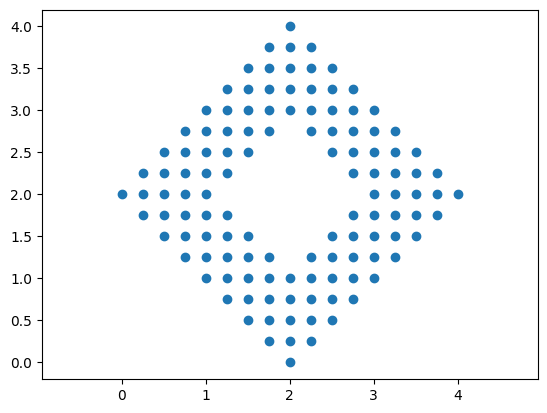

In [18]:
#Defining nodes
RESOLUTION = 4 #input 1, 2 or 4
step = 1/RESOLUTION
y_cor = 4
node_list = []
while y_cor <= 4 and y_cor >= 2:
    x_cor = 0
    while x_cor >= 0 and x_cor <= 4:
        if (x_cor >= y_cor-2) and (x_cor <= 6-y_cor):
            if (x_cor <= y_cor-1) or (x_cor >= 5-y_cor):
                node_list.append([x_cor, y_cor])
        x_cor += step
    y_cor -= step

while y_cor < 2 and y_cor >= 0:
    x_cor = 0
    while x_cor >= 0 and x_cor <= 4:
        if (x_cor <= y_cor+2) and (x_cor >= 2-y_cor):
            if (x_cor >= y_cor+1) or (x_cor <= 3-y_cor):
                node_list.append([x_cor, y_cor])
        x_cor += step
    y_cor -= step


nodes = np.array(node_list)
plt.plot(nodes[:,0], nodes[:,1], 'o')
plt.axis('equal')
plt.show()

To create elements from node, we will utilize the Delaunay triangulation, which is the algorithm compute the triangular mesh from a given set of points.
The Delaunay triangulation is already defined in ```scipy.spatial``` package, which we have already imported above.

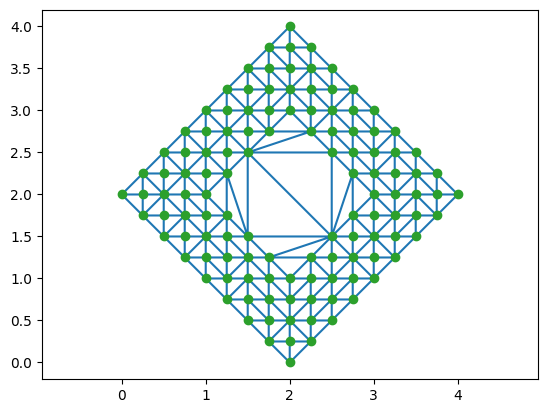

In [19]:
tri = Delaunay(nodes)
plt.triplot(nodes[:,0], nodes[:,1], tri.simplices)
plt.plot(nodes[:,0], nodes[:,1], 'o')
plt.axis('equal')
plt.show()

Now, we have obtained the set of elements ```tri```. However, the algorithm also created elements inside the hole that should be empty.
So, we will first define nodes inside the hole in the ```hole_node_list```. Then, we will find the elements that contain those points, using ```tri.find_simplex(hole_nodes)``` method, and remove them from ```tri```. The final list of elements is called ```element_list```

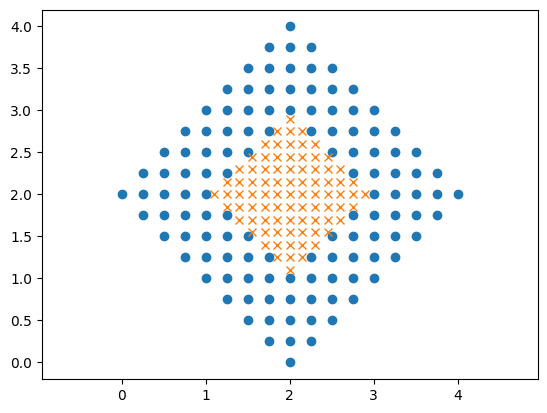

In [20]:
hole_node_list = []
hole_step = 0.15
y_cor = 2.9
while y_cor <= 2.9 and y_cor > 2:
    x_cor = 1.1
    while x_cor >= 0 and x_cor <= 4:
        if (x_cor >= y_cor-1) and (x_cor <= 5-y_cor):
            hole_node_list.append([x_cor, y_cor])
        x_cor += hole_step
    y_cor -= hole_step

while y_cor > 1:
    x_cor = 1.1
    while x_cor >= 0 and x_cor <= 4:
        if (x_cor <= y_cor+1) and (x_cor >= 3-y_cor):
            hole_node_list.append([x_cor, y_cor])
        x_cor += hole_step
    y_cor -= hole_step


nodes = np.array(node_list)
hole_nodes = np.array(hole_node_list)
plt.plot(nodes[:,0], nodes[:,1], 'o')
plt.plot(hole_nodes[:,0], hole_nodes[:,1], 'x')
plt.axis('equal')
plt.show()

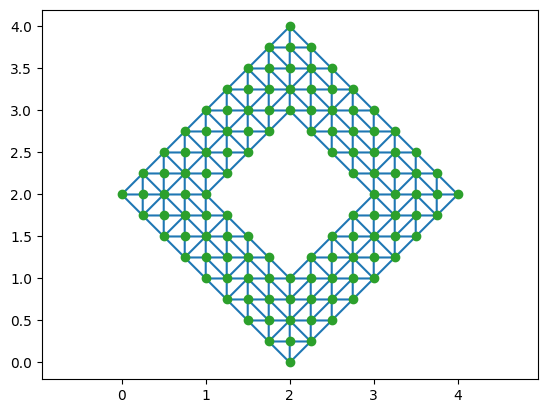

In [21]:
# Find the elements which contain those points
hole_elements = list(set(tri.find_simplex(hole_nodes)))
hole_elements.sort()

# Remove elements that contain those points
element_list = np.delete(tri.simplices, hole_elements, 0)

plt.triplot(nodes[:,0], nodes[:,1], element_list)
plt.plot(nodes[:,0], nodes[:,1], 'o')
plt.axis('equal')
plt.show()

Here, we will show the format of the ```element_list```, which each element contains 3 node indices. The coordinate of each index can be found in ```nodes``` array.

In [22]:
# Display the mesh indices and coordinates
print("Example - Element list:\nindex   node indices")
for i, element in enumerate(element_list[:5]):
    print(f"  {i}        {element}")

print("\nExample - Nodes:\nindex   coordinate (x, y)")
for i, node in enumerate(nodes[:5]):
    print(f"  {i}         ({node[0]}, {node[1]})")

Example - Element list:
index   node indices
  0        [75 85 76]
  1        [86 85 95]
  2        [110 109 115]
  3        [114 118 115]
  4        [15  8 14]

Example - Nodes:
index   coordinate (x, y)
  0         (2.0, 4.0)
  1         (1.75, 3.75)
  2         (2.0, 3.75)
  3         (2.25, 3.75)
  4         (1.5, 3.5)


### 2. Finding stiffness matrix of each element and total stiffness matrix of the material

The stiffness matrix $K_n$ of each element can be computed using the following formula:  
$$K_n = a_n  B_n^T  D  B_n$$
, where $a_n$ is the area of the element, $B$ matrix is the matrix that shows the realationship between the displacement and strain of each element, and $D$ matrix is the Elastic modulus matrix.

Since $D$ matrix is a constant for the material, only depending on Young's modulus ($E$) and poisson ratio ($\nu$), we will first start by defining it. However, $D$ matrix also varies in different conditions.
In plain strain condition, $D$ matrix is expressed by:
$$D = \frac{E}{(1+\nu)(1-2\nu)}\begin{bmatrix}1-\nu & \nu & 0\\\nu & 1-\nu & 0\\0 & 0 & \frac{1-2\nu}{2}\end{bmatrix}$$
On the other hand, in plain stress condition, $D$ matrix is expressed by:
$$D = \frac{E}{(1+\nu)(1-\nu)}\begin{bmatrix}
1 & \nu & 0\\
\nu & 1 & 0\\
0 & 0 & \frac{1-\nu}{2}
\end{bmatrix}$$

Using the Aluminum alloy 1100, the Young's modulus is 69 GPa and the poisson ratio is 0.33

In [23]:
v_ratio = 0.33
E = 69*(10**9)

# Defining Elastic modulus matrix (D)
def D_matrix_strain_cond(E, v_ratio): 
    D = (E/((1+v_ratio)*(1-2*v_ratio)))*np.array([[1-v_ratio, v_ratio, 0],
                                                [v_ratio, 1-v_ratio, 0],
                                                [0, 0, (1-2*v_ratio)/2]])
    return D

def D_matrix_stress_cond(E, v_ratio): 
    D = (E/((1+v_ratio)*(1-v_ratio)))*np.array([[1, v_ratio, 0],
                                                [v_ratio, 1, 0],
                                                [0, 0, (1-v_ratio)/2]])
    return D

# Compute D_matrix (can change the condition by changing the function)
D = D_matrix_stress_cond(E, v_ratio)
print("Elastic modulus matrix (D):\n", D)

Elastic modulus matrix (D):
 [[7.74323869e+10 2.55526877e+10 0.00000000e+00]
 [2.55526877e+10 7.74323869e+10 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.59398496e+10]]


Since each $B$ matrix is specific to an element, we will define a function ```B_matrix_and_area()``` that compute $B$ matrix and area ($a_n$) of each elements. Then, we will loop over every elements and put each element's $B$ matrix and area into ```B_list``` and ```area_list``` according to its element index.

The formula of $B$ matrix is shown as follows:
$$B = \begin{bmatrix}
\frac{\partial{N_1}}{\partial{x}} & 0 & \frac{\partial{N_2}}{\partial{x}} & 0 & \frac{\partial{N_3}}{\partial{x}} & 0\\
0 & \frac{\partial{N_1}}{\partial{y}} & 0 & \frac{\partial{N_2}}{\partial{y}} & 0 & \frac{\partial{N_3}}{\partial{y}}\\
\frac{\partial{N_1}}{\partial{y}} & \frac{\partial{N_1}}{\partial{x}} & \frac{\partial{N_2}}{\partial{y}} & \frac{\partial{N_2}}{\partial{x}} & \frac{\partial{N_3}}{\partial{y}} & \frac{\partial{N_3}}{\partial{x}}
\end{bmatrix}$$
, where 
$$\frac{\partial{N_1}}{\partial{x}}=\frac{y_2-y_3}{2a},\quad\frac{\partial{N_2}}{\partial{x}}=\frac{y_3-y_1}{2a},\quad\frac{\partial{N_3}}{\partial{x}}=\frac{y_1-y_2}{2a}$$
$$\frac{\partial{N_1}}{\partial{y}}=\frac{x_3-x_2}{2a},\quad\frac{\partial{N_2}}{\partial{y}}=\frac{x_1-x_3}{2a},\quad\frac{\partial{N_3}}{\partial{y}}=\frac{x_2-x_1}{2a}$$
, and
$$a = \frac{1}{2}det\begin{bmatrix}
1 & x_1 & y_1\\
1 & x_2 & y_2\\
1 & x_3 & y_3
\end{bmatrix}$$

In [24]:
# Defining a function to compute B matrix
def B_matrix_and_area(element_index, nodes_coordinate):
    # mesh_node is the array containing 3 node indices = element in mesh
    # nodes_coordinate is the array containing coordinate of each node indix = nodes
    node1, node2, node3 = element_list[element_index]

    node1_x, node1_y = nodes_coordinate[node1]
    node2_x, node2_y = nodes_coordinate[node2]
    node3_x, node3_y = nodes_coordinate[node3]

    area = 0.5*np.linalg.det(np.array([[1, node1_x, node1_y],
                                       [1, node2_x, node2_y],
                                       [1, node3_x, node3_y]]))

    dN1_dx = (node2_y - node3_y)/(2*area)
    dN2_dx = (node3_y - node1_y)/(2*area)
    dN3_dx = (node1_y - node2_y)/(2*area)
    dN1_dy = (node3_x - node2_x)/(2*area)
    dN2_dy = (node1_x - node3_x)/(2*area)
    dN3_dy = (node2_x - node1_x)/(2*area)

    B_matrix = np.array([[dN1_dx, 0, dN2_dx, 0, dN3_dx, 0],
                  [0, dN1_dy, 0, dN2_dy, 0, dN3_dy],
                  [dN1_dy, dN1_dx, dN2_dy, dN2_dx, dN3_dy, dN3_dx]])
    return (B_matrix, area)

# Compute B matrix of each element and put them into B_list
B_list = []
area_list = []

for i in range(len(element_list)):
    B_tuple = B_matrix_and_area(i, nodes)
    B_list.append(B_tuple[0])
    area_list.append(B_tuple[1])

print("The B matrix of element 0:\n", B_list[0], "\n")
print("The area of element 0:\n", area_list[0])

The B matrix of element 0:
 [[-4.  0.  0.  0.  4.  0.]
 [ 0.  0.  0. -4.  0.  4.]
 [ 0. -4. -4.  0.  4.  4.]] 

The area of element 0:
 0.03125


Now, we will define a function ```K_matrix()```, which will input area and $B$ matrix of each element and compute $K_n$ matrix.
Then, similar to before, we will loop over every element, compute $K_n$ and put it in ```K_list``` according to the element index.

In [25]:
# Defining a function to compute B matrix
def K_matrix(area, B_matrix, D_matrix):
    K = area*B_matrix.transpose().dot((D_matrix.dot(B_matrix)))
    return K

# Computing K matrix for each element and put them into K_list
K_list = []
for i in range(len(element_list)):
    K_list.append(K_matrix(area_list[i], B_list[i], D))

print("The K matrix of element 0:\n", K_list[0])


The K matrix of element 0:
 [[ 3.87161935e+10  0.00000000e+00  0.00000000e+00  1.27763438e+10
  -3.87161935e+10 -1.27763438e+10]
 [ 0.00000000e+00  1.29699248e+10  1.29699248e+10  0.00000000e+00
  -1.29699248e+10 -1.29699248e+10]
 [ 0.00000000e+00  1.29699248e+10  1.29699248e+10  0.00000000e+00
  -1.29699248e+10 -1.29699248e+10]
 [ 1.27763438e+10  0.00000000e+00  0.00000000e+00  3.87161935e+10
  -1.27763438e+10 -3.87161935e+10]
 [-3.87161935e+10 -1.29699248e+10 -1.29699248e+10 -1.27763438e+10
   5.16861183e+10  2.57462687e+10]
 [-1.27763438e+10 -1.29699248e+10 -1.29699248e+10 -3.87161935e+10
   2.57462687e+10  5.16861183e+10]]


Now that we obtained the $K$ matrix for each element, we will define ```K_total_matrix()``` function to superimpose every $K$ matrix according to their node to compute the total stiffness matrix ($K_t$). To do that, first, we need to increase the dimension of each $K$ matrix to [2n(node) $\times$ 2n(node)]. The increased dimensionality marix is defined as ```Ke```. Then, we will loop over ```Ke``` and performed element-wise addition to superimpose them.

In [26]:
# Combine all K matrices to create the total stiffness matrix
def K_total_matrix(K_list, element_list, total_nodes):
    #test_output = []
    K_t = np.zeros((total_nodes*2, total_nodes*2))

    for i in range(len(K_list)):
        K_e = np.zeros((total_nodes*2, total_nodes*2))
        element = element_list[i]
                
        for row in range(6):
            row_node = element[row//2]
            for col in range(6):
                col_node = element[col//2]
                if (row%2==0) and (col%2==0):
                    K_e[row_node*2][col_node*2] = K_list[i][row][col]
                elif (row%2==0) and (col%2==1):
                    K_e[row_node*2][(col_node*2)+1] = K_list[i][row][col]
                elif (row%2==1) and (col%2==0):
                    K_e[(row_node*2)+1][col_node*2] = K_list[i][row][col]
                elif (row%2==1) and (col%2==1):
                    K_e[(row_node*2)+1][(col_node*2)+1] = K_list[i][row][col]
        #test_output.append(K_e)
        K_t += K_e
    return K_t

# Compute the total stiffness matrix
K_t = K_total_matrix(K_list, element_list, len(nodes))

 
# save the dataframe as a csv file
K_t_DF = pd.DataFrame(K_t)
K_t_DF.to_csv("Total_stiffness_matrix.csv")


### 3. Compute the displacement of each node to obtain the deformed shape
Now that we obtained total stiffness matrix ```K_t```, we can compute the displacement vector $u$, by using the following relation:
$$K_t u = f$$

Since our geometry is symmetric to the axis $x = 2$, and the force will only be applied in the vertical direction at the symmetric axis, the node at the symmetric axis will have displacement in x-direction equals to zero (excluding the node that the force is applied, ```node_for_pulling```). Moreover, the base node, which is fixed, will have the displacement in y-direction equals to zero as well. Because of that, some entries in $u$ vector will equal to 0, and they need to be excluded from the $K_t$ matrix before computing the $u$ vector.

In [27]:
# Find nodes that in the middle (u_x = 0)
node_for_pullling = 0
row_to_crop = []
for i in range(len(nodes)):
    if nodes[i][0] == 2:    
        if nodes[i][1] == 0:            # Condition for Based node
            row_to_crop.append(i*2)
            row_to_crop.append(i*2+1)
        elif nodes[i][1] == 4:
            node_for_pullling = i
        else:
            row_to_crop.append(i*2)     # Appending the node that displacement in x direction = 0
print("Rows that should be cropped:\n",row_to_crop)

row_to_crop.sort(reverse=True)
K_t_crop = K_t
for i in row_to_crop:
    K_t_crop = np.delete(K_t_crop, i, 0)
    K_t_crop = np.delete(K_t_crop, i, 1)

# Computing u vector
# Defining force vector
f_vector = np.zeros((len(nodes)*2-len(row_to_crop),1))
f_vector[1][0] = 8*(10**9)
K_t_crop_inv = linalg.inv(K_t_crop)
u_vector = K_t_crop_inv.dot(f_vector)



Rows that should be cropped:
 [4, 12, 24, 40, 198, 214, 226, 234, 238, 239]


Since the matrix is cropped before the computation, the resulted $u$ vector will have less dimension than the actual displacement vector. The following code is meant to append the value of ```u_vector``` into ```displacement``` vector, according to their node index.

In [28]:
displacement = np.zeros((len(nodes),2))
k = 0
w = 0
for i in range(len(displacement)):
    for j in range(2):
        if k not in row_to_crop:
            displacement[i][j] = u_vector[w]
            w += 1
        k += 1

print("Example - Displacement:")
print("node            (x-displacement, y-displacement)")
for i, dis in enumerate(displacement[:5]):
    print(f" {i}         ({dis[0]}, {dis[1]})")


Example - Displacement:
node            (x-displacement, y-displacement)
 0         (-0.0004053319358219298, 1.4686170268799388)
 1         (-0.0007025303921007468, 1.2880619615005093)
 2         (0.0, 1.3666530712329437)
 3         (0.0074913264684439785, 1.288872625372153)
 4         (-0.02840341112219193, 1.1820775780717636)


After we obtained the ```displacement``` vector, we can obtain the new coordinates by adding the displacement into the old coordinate and plot them.

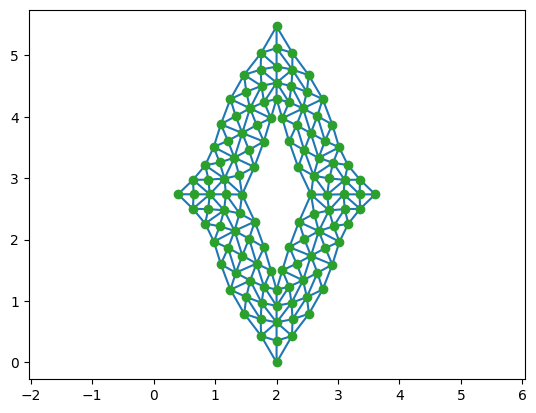

In [29]:
new_nodes = nodes + displacement

plt.triplot(new_nodes[:,0], new_nodes[:,1], element_list)
plt.plot(new_nodes[:,0], new_nodes[:,1], 'o')
plt.axis('equal')
plt.show()

### 4. Compute the strain of each element
The strain of each element can be computed using the following relation:
$$\varepsilon = Bd$$
$$\begin{Bmatrix}
\varepsilon_{xx}\\
\varepsilon_{yy}\\
2\varepsilon_{xy}
\end{Bmatrix}
=\begin{bmatrix}
\frac{\partial{N_1}}{\partial{x}} & 0 & \frac{\partial{N_2}}{\partial{x}} & 0 & \frac{\partial{N_3}}{\partial{x}} & 0\\
0 & \frac{\partial{N_1}}{\partial{y}} & 0 & \frac{\partial{N_2}}{\partial{y}} & 0 & \frac{\partial{N_3}}{\partial{y}}\\
\frac{\partial{N_1}}{\partial{y}} & \frac{\partial{N_1}}{\partial{x}} & \frac{\partial{N_2}}{\partial{y}} & \frac{\partial{N_2}}{\partial{x}} & \frac{\partial{N_3}}{\partial{y}} & \frac{\partial{N_3}}{\partial{x}}
\end{bmatrix}
\begin{Bmatrix}
u_{1x}\\
u_{1y}\\
u_{2x}\\
u_{2y}\\
u_{3x}\\
u_{3y}
\end{Bmatrix}$$
To compute that, we will define a ```strain_vector()``` function, which compute each element strain vector ($\varepsilon$). Then, loop over every element to compute every element's strain vector, and plot them using color gradient to show the distribution of strain.

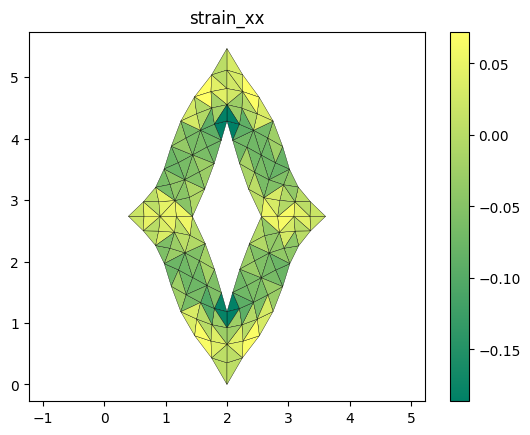

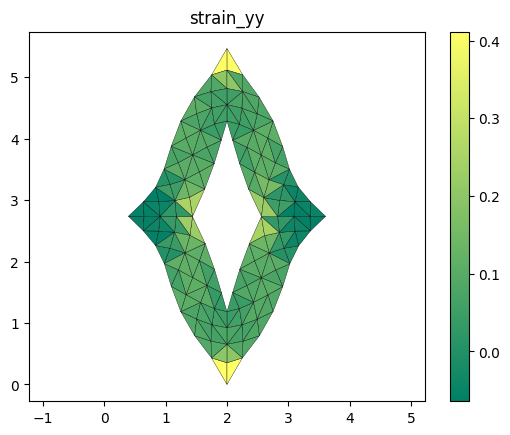

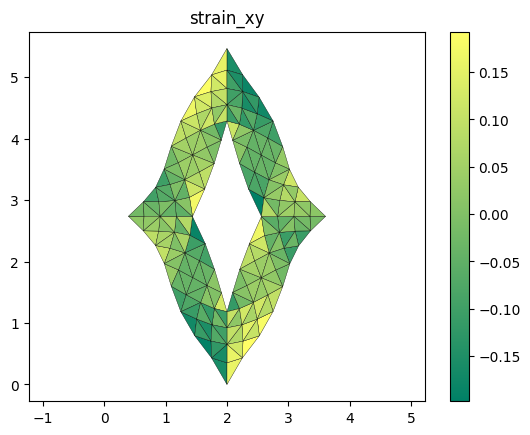

In [30]:
# Defining the function to compute strain vector
def strain_vector(B_matrix, element_index, displacement):
    node1, node2, node3 = element_list[element_index]
    disp = np.array([[displacement[node1][0]],
                     [displacement[node1][1]],
                     [displacement[node2][0]],
                     [displacement[node2][1]],
                     [displacement[node3][0]],
                     [displacement[node3][1]]])
    
    strain = B_matrix.dot(disp)
    return strain

# Loopoing over every element to obtain every element's strain vector
strain_list = []
for i in range(len(element_list)):
    strain_list.append(strain_vector(B_list[i], i, displacement))

# Plotting strain
colormap = "summer"

strain_xx_list = np.array([strain_list[i][0][0] for i in range(len(element_list))])
plt.tripcolor(new_nodes[:,0], new_nodes[:,1], element_list, facecolors=strain_xx_list, edgecolors='k', cmap=colormap)
plt.gca().set_aspect('equal')
plt.axis('equal')
plt.colorbar()
plt.title("strain_xx")
plt.show()

strain_yy_list = np.array([strain_list[i][1][0] for i in range(len(element_list))])
plt.tripcolor(new_nodes[:,0], new_nodes[:,1], element_list, facecolors=strain_yy_list, edgecolors='k', cmap=colormap)
plt.gca().set_aspect('equal')
plt.axis('equal')
plt.colorbar()
plt.title("strain_yy")
plt.show()

strain_xy_list = np.array([strain_list[i][2][0] for i in range(len(element_list))])
plt.tripcolor(new_nodes[:,0], new_nodes[:,1], element_list, facecolors=strain_xy_list/2, edgecolors='k', cmap=colormap)
plt.gca().set_aspect('equal')
plt.axis('equal')
plt.colorbar()
plt.title("strain_xy")
plt.show()
    
    

### 5. Compute the strain of each element
The stress of each element can be computed using the following relation:
$$\sigma = D\varepsilon$$
$$\begin{Bmatrix}
\sigma_{xx}\\
\sigma_{yy}\\
\sigma_{xy}
\end{Bmatrix}
=D\begin{Bmatrix}
\varepsilon_{xx}\\
\varepsilon_{yy}\\
2\varepsilon_{xy}
\end{Bmatrix}$$
To compute that, we will define a ```stress_vector()``` function, which compute each element strain vector ($\sigma$). Then, loop over every element to compute every element's stress vector, and plot them using color gradient to show the distribution of stress.

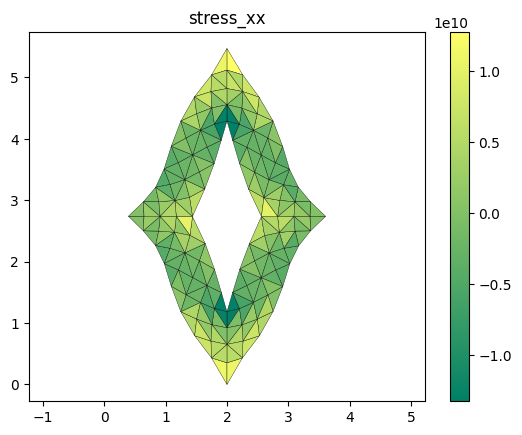

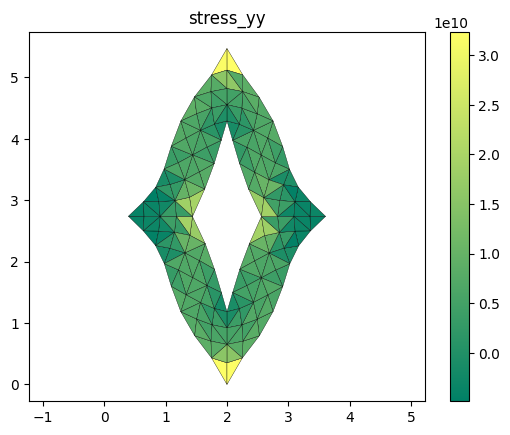

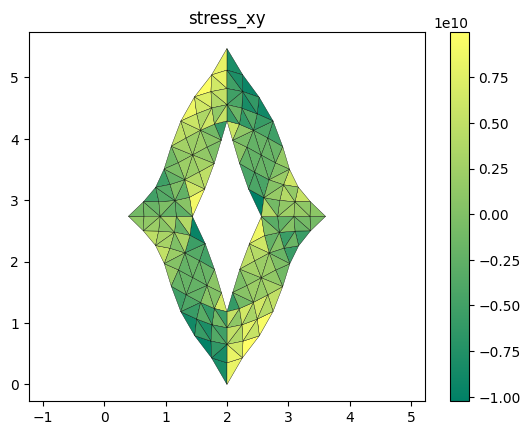

In [31]:
# Defining the function to compute stress vector
def stress_vector(D_matrix, strain_vector):
    stress = D_matrix.dot(strain_vector)
    return stress

# Loopoing over every element to obtain every element's stress vector
stress_list = []
for i in range(len(element_list)):
    stress_list.append(stress_vector(D, strain_list[i]))

# Plotting stress
colormap = "summer"

stress_xx_list = np.array([stress_list[i][0][0] for i in range(len(element_list))])
plt.tripcolor(new_nodes[:,0], new_nodes[:,1], element_list, facecolors=stress_xx_list, edgecolors='k', cmap=colormap)
plt.gca().set_aspect('equal')
plt.axis('equal')
plt.colorbar()
plt.title("stress_xx")
plt.show()

stress_yy_list = np.array([stress_list[i][1][0] for i in range(len(element_list))])
plt.tripcolor(new_nodes[:,0], new_nodes[:,1], element_list, facecolors=stress_yy_list, edgecolors='k', cmap=colormap)
plt.gca().set_aspect('equal')
plt.axis('equal')
plt.colorbar()
plt.title("stress_yy")
plt.show()

stress_xy_list = np.array([stress_list[i][2][0] for i in range(len(element_list))])
plt.tripcolor(new_nodes[:,0], new_nodes[:,1], element_list, facecolors=stress_xy_list, edgecolors='k', cmap=colormap)
plt.gca().set_aspect('equal')
plt.axis('equal')
plt.colorbar()
plt.title("stress_xy")
plt.show()